# Introduction

In this project, we will be working with data from the S&P500 Index. The S&P500 is a stock market index. Before we get into what an index is, we'll need to get into the basics of the stock market.

Some companies are publicly traded, which means that anyone can buy and sell their shares on the open market. A share entitles the owner to some control over the direction of the company, and to some percentage (or share) of the earnings of the company. When we buy or sell shares, it's common to say that we are trading a stock.

The price of a share is based mainly on supply and demand for a given stock. For example, Apple stock has a price of 120 dollars per share as of December 2015 -- http://www.nasdaq.com/symbol/aapl. A stock that is in less demand, like Ford Motor Company, has a lower price -- http://finance.yahoo.com/q?s=F. Stock price is also influenced by other factors, including the number of shares a company has issued.

Stocks are traded daily, and the price can rise or fall from the beginning of a trading day to the end based on demand. Stocks that are in more in demand, such as Apple, are traded more often than stocks of smaller companies.

Indexes aggregate the prices of multiple stocks together, and allow us to see how the market as a whole is performing. For example, the Dow Jones Industrial Average aggregates the stock prices of 30 large American companies together. The S&P500 Index aggregates the stock prices of 500 large companies. When an index fund goes up or down, we can say that the underlying market or sector it represents is also going up or down. For example, if the Dow Jones Industrial Average price goes down one day, we can say that American stocks overall went down (ie, most American stocks went down in price).

we will be using historical data on the price of the S&P500 Index to make predictions about future prices. Predicting whether an index will go up or down will help us forecast how the stock market as a whole will perform. Since stocks tend to correlate with how well the economy as a whole is performing, it can also help us make economic forecasts.

In [1]:
# Importing Resources

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from time import time

import warnings
warnings.filterwarnings('ignore')

# Exploring the Data

We will be using the sphist.csv dataset which contains the prices of the S&P500 index from 1950 to 2015.

In [2]:
# Creating a dataframe of the S&P500 dataset

df = pd.read_csv('sphist.csv')

df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


We can see that the dataset has several columns which are:

- `Date`: The date of the record.


- `Open`: The opening price of the day (when trading starts).


- `High`: The highest trade price during the day.


- `Low`: The lowest trade price during the day.


- `Close`: The closing price for the day (when trading is finished).


- `Volume`: The number of shares traded.


- `Adj Close`: The daily closing price, adjusted retroactively to include any corporate actions. 

All the prices are in American Dollars $. In this problem, we will be using the `Close` column as the target (The value we are trying to predict). 

# Preparing the Data


## Data Types

First, we need to ensure that the columns are of the correct data types.

In [3]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

All columns are of the correct data types except the `Date` column which is an object. We will need to convert the column to datetime type for us to be able to split the dataset into train and test dataset by using datetime comparisons.

In [4]:
df["Date"] = pd.to_datetime(df["Date"])

df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume              float64
Adj Close           float64
dtype: object

## Re-ordering of the Dataset

When we printed the first five rows of the dataset above, it can be seen that the rows are ordered by the `Date` column in descending order. We want it to be in ascending order for the upcoming steps.

In [5]:
# Sort data in descending order

df = df.sort_values(by='Date')

df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


## Missing Data

It is always important to check if there is any missing data as it can massively affect the performance of machine learning algorithms

In [6]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

We have got no missing values, and our dataset has been prepared for training models and making predictions. The next step is to generate some indicators that would assist us in making accurate predictions.

# Generating Indicators

Datasets taken from the stock market need to be handled differently than datasets from other sectors when it comes to making predictions. In a normal machine learning exercise, we treat each row as independent. Stock market data is sequential, and each observation comes a day after the previous observation. Thus, the observations are not all independent, and we can't treat them as such.

This means we have to be extra careful to not inject "future" knowledge into past rows when we do training and prediction. Injecting future knowledge will make our model look good when we are training and testing it, but will make it fail in the real world. This is how many algorithmic traders lose money.

The time series nature of the data means that we can generate indicators to make our model more accurate. For instance, we can create a new column that contains the average price of the last 10 trades for each row. This will incorporate information from multiple prior rows into one, and will make predictions much more accurate.

When we do this, we have to be careful not to use the current row in the values we average. We want to teach the model how to predict the current price from historical prices. If we include the current price in the prices we average, it will be equivalent to handing the answers to the model upfront, and will make it impossible to use in the "real world", where we don't know the price upfront. we will use `shift()` to shift all the values forward by one day.

Here are some indicators that are interesting to generate for each row:

    The average price from the past 5 days.
    The average price for the past 30 days.
    The average price for the past 365 days.
    The ratio between the average price for the past 5 days, and the average price for the past 365 days.
    The standard deviation of the price over the past 5 days.
    The standard deviation of the price over the past 365 days.
    The ratio between the standard deviation for the past 5 days, and the standard deviation for the past 365 days.

"Days" means "trading days" -- so if we're computing the average of the past 5 days, it should be the 5 most recent dates before the current one. We will assume that "price" is the `Close` column.

In [7]:
# Average price of the past 5, 30 and 365 days
day_5 = df["Close"].rolling(5).mean().shift(1)
day_30 = df["Close"].rolling(30).mean().shift(1)
day_365 = df["Close"].rolling(365).mean().shift(1)

# Ratio of the past 5 to 365 days
ratio_5_to_365 = day_5 / day_365

# Standard deviation of the past 5 and 365 days
day_5_std = df["Close"].rolling(5).std().shift(1)
day_365_std = df["Close"].rolling(365).std().shift(1)

# Ratio of the standard deviation of the past 5 to 365 days
ratio_std_5_to_365 = day_5_std / day_365_std

# Add to main dataframe

df['day_5'] = day_5
df['day_30'] = day_30
df['day_365'] = day_365
df['ratio_5_to_365'] = ratio_5_to_365
df['day_5_std'] = day_5_std
df['day_365_std'] = day_365_std
df['ratio_std_5_to_365'] = ratio_std_5_to_365

# Evaluation of Different Supervised Models

In this section we will investigate three different supervised learners, and determine which is best at modeling the data.

## Training and Predicting Pipeline

We will be testing several models, therefore, it is important to create a set of functions that allow us to quickly and effectively train models and perform predictions. This will also help us avoid replication of the same code.

The first function `train_test_split` splits the dataset into a train and test set. As we mentioned before, the data set contains the prices of the S&P indices from 1950 to 2015. We will be using all data from 1950 to 2013 to train the model, and all data from 2013 to 2015 to test and evaluate the performance of the models.

These datasets will be used in the `train_predict` function to train and test the different supervised learners.

In [58]:
# Function used to split the data into a train and test dataset

def train_test_split(df, features):
    
    df = df.dropna(axis=0)

    train = df[df["Date"] < datetime(year=2013, month=1, day=1)]
    test = df[df["Date"] >= datetime(year=2013, month=1, day=1)]

    x_train = train[features]
    y_train = train["Close"]

    x_test = test[features]
    y_test = test["Close"]
    
    test_date = test['Date']
    
    return x_train, y_train, x_test, y_test, test_date

In [62]:
# Function used to train a model and perform predictions on the testing data

def train_predict(learner, features, df): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    x_train, y_train, x_test, y_test, test_date = train_test_split(df, features)
    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner = learner.fit(x_train, y_train)
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set(X_test)
    # then get predictions on the training set
    start = time() # Get start time
    predictions_test = learner.predict(x_test)
    predictions_train = learner.predict(x_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute rmse on train set
    mse_train = mean_squared_error(y_train,predictions_train)
    results['rmse_train'] = np.sqrt(mse_train)
        
    # Compute rmse on test set
    mse_test = mean_squared_error(y_test, predictions_test)
    results['rmse_test'] = np.sqrt(mse_test)
    
    # Compute mae on train set
    results['mae_train'] = mean_absolute_error(y_train,predictions_train)
        
    # Compute mae on test set
    results['mae_test'] = mean_absolute_error(y_test, predictions_test)
        
    # Return the results
    return results

The `evaluate` function below will be used to plot various performance metrics from the three different supervised learners for us to easily determine the best performing model.

In [83]:
def evaluate(results):
    """
    Visualization code to display results of various learners.

    inputs:
      - results: Dictionary including stats from different learners
    """

    # Create figure
    fig, ax = plt.subplots(2, 3, figsize=(15, 9))

    # Constants
    bar_width = 0.45
    colors = ['#A00000', '#00A0A0', '#00A000']

    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'rmse_train', 'mae_train', 'pred_time', 'rmse_test', 'mae_test']):
            # Creative plot code
            ax[j // 3, j % 3].bar(k + bar_width, results[learner][metric], width=bar_width, color=colors[k])

    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("RMSE (in $)")
    ax[0, 2].set_ylabel("MAE (in $)")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("RMSE (in $)")
    ax[1, 2].set_ylabel("MAE (in $)")

    # Hide x-axis
    ax[0, 0].tick_params(bottom=False)
    ax[0, 0].set(xticklabels=[])
    ax[0, 1].tick_params(bottom=False)
    ax[0, 1].set(xticklabels=[])
    ax[0, 2].tick_params(bottom=False)
    ax[0, 2].set(xticklabels=[])
    ax[1, 0].tick_params(bottom=False)
    ax[1, 0].set(xticklabels=[])
    ax[1, 1].tick_params(bottom=False)
    ax[1, 1].set(xticklabels=[])
    ax[1, 2].tick_params(bottom=False)
    ax[1, 2].set(xticklabels=[])

    # Add titles
    ax[0, 0].set_title("Model Training Time")
    ax[0, 1].set_title("RMSE on Training Subset")
    ax[0, 2].set_title("MAE on Training Subset")
    ax[1, 0].set_title("Model Predicting Time")
    ax[1, 1].set_title("RMSE on Testing Set")
    ax[1, 2].set_title("MAE on Testing Set")

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color=colors[i], label=learner))
    plt.legend(handles=patches, bbox_to_anchor=(-.80, 2.53), \
               loc='upper center', borderaxespad=0., ncol=3, fontsize='x-large')

    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize=16, y=1.10)
    plt.show()

## Supervised Learning Models

The three supervised models I chose to test for this problem are:

- Random Forest
- Support Vector Regression (SVR)
- Linear Regression

**elaborate further**

## Model Evaluation

In this step we will import the models, use the functions created earlier to train and test the models, and to finally plot the different perfomance metrics of all the models.

RandomForestRegressor has been trained
SVR has been trained
LinearRegression has been trained


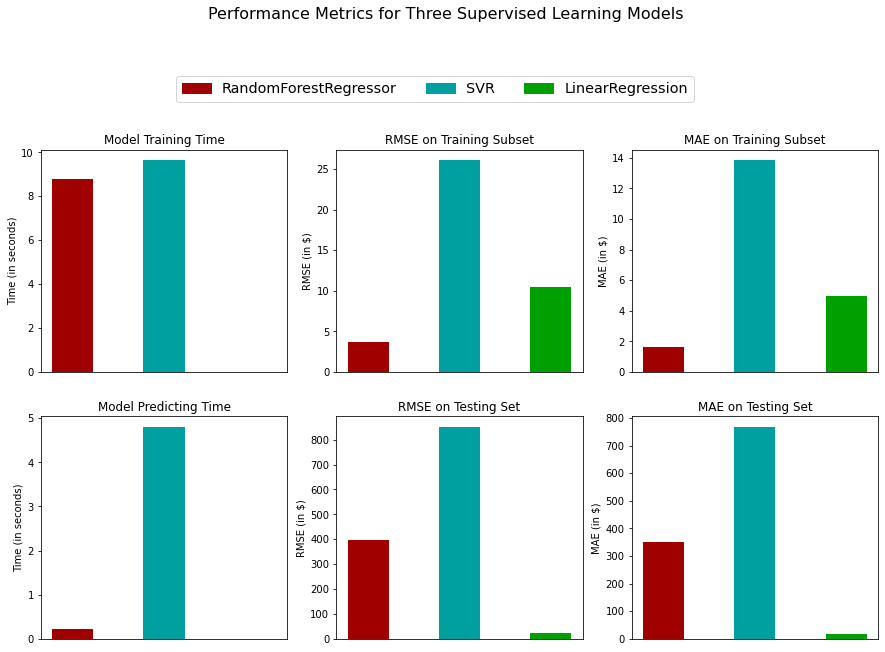

In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

reg_A = RandomForestRegressor(random_state=42)
reg_B = SVR()
reg_C = LinearRegression()

features = ['day_5', 'day_30', 'day_365', 'ratio_5_to_365', 'day_5_std', 'day_365_std', 'ratio_std_5_to_365']

# Collect results on the learners
results = {}
for reg in [reg_A, reg_B, reg_C]:
    reg_name = reg.__class__.__name__
    results[reg_name] = train_predict(reg, features, df)
    print("{} has been trained".format(reg_name))

# Run metrics visualization for the three supervised learning models chosen
# evaluate(results)
evaluate(results)

# Improving Results

In this section we will chose the best model, create more indicators, and then use feature importance to only use the indicators that have a significant effect of the predicition ability of the model.

## Selection of Best Model

It can be seen above that the SVR perfomed poorly. It had the highest training and prediction time, and also had the highest errors on both the training and testing set. This doesnt look very promising, and it leaves us to choose between the RandomForestRegressor and the LinearRegression model.

The RandomForestRegressor took a significant amount of time to train the model, but was very quick on performing predictions. It had a very low rmse and mae on the training set, but a relatively high rmse and mae on the testing set. This shows that the RandomForestRegressor is overfitting to the training data, and fails to generalize well and make accurate predictions on unseen data.

The LinearRegression model was the quickest when it came to both training the model and making predictions. It had a higher rmse and mae than the RandomForestRegressor on the training set, but very low error values when it came to testing set. This shows that the LinearRegression model manages to generalize really well on unseen data, making it the best model out of the three tested. Also, it having very low training and prediction times is a bonus as it can be used to make real-time predictions.

We have discovered that the LinearRegression model works very well on our problem. The next step is to optimize the model by choosing the features that result in the best predictions. As we will be testing the LinearRegression model multiple times using different set of features, we create the `lr_train_test` function to make this process easier. This function trains and test a linear regression model using a set of desired features, and prints out the MAE and RMSE while also plotting the actual `Close` prices of the test set against the predictions made by the model

In [71]:
def lr_train_test(df, features):
    
    x_train, y_train, x_test, y_test, test_date = train_test_split(df, features)

    lr = LinearRegression()

    lr.fit(x_train, y_train)

    predictions = lr.predict(x_test)

    mae = mean_absolute_error(y_test, predictions)

    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    
    
    print("The MAE is {:.2f}, and the RMSE is {:.2f}".format(mae, rmse))
    
    plt.figure(figsize=(15,4))

    plt.plot(test_date, y_test, label='True Price')
    plt.plot(test_date, predictions, label='Predicted Price')

    plt.ylabel("Stock Price ($)")
    plt.xlabel("Date of Trade")

    plt.xticks(rotation=-45)

    plt.legend()
    plt.show()
    
    return lr

Let's test the function on the features we used to previously evaluate the three supervised learners.

The MAE is 16.15, and the RMSE is 22.20


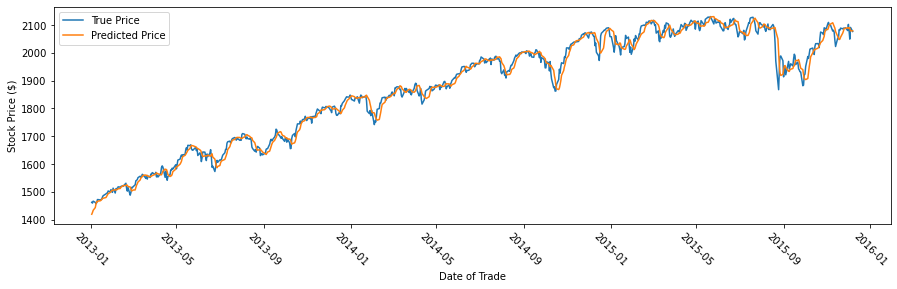

LinearRegression()

In [72]:
lr_train_test(df, features)

The graph shows that the model produces very good predictions and manages to accurately follow the trends of the stock price. 

## Generation of Additional Indicators

So far we have only used features that are based on the `Close` price of the stock. The volume of stocks traded could play a vital role in providing the model with necessary information for making more accurate predictions. Below we will generate features using `Volume`, similiar to features previously generated using the `Close` column.

In [73]:
# Average volume of the past 5, 30 and 365 days
volume_5 = df["Volume"].rolling(5).mean().shift(1)
volume_30 = df["Volume"].rolling(30).mean().shift(1)
volume_365 = df["Volume"].rolling(365).mean().shift(1)

# Ratio of the past 5 to 365 days
volume_5_to_365 = volume_5 / volume_365

# Standard deviation of the past 5 and 365 days
volume_5_std = df["Volume"].rolling(5).std().shift(1)
volume_365_std = df["Volume"].rolling(365).std().shift(1)

# Ratio of the standard deviation of the past 5 to 365 days
volume_std_5_to_365 = volume_5_std / volume_365_std

# Add to main dataframe

df['volume_5'] = volume_5
df['volume_30'] = volume_30
df['volume_365'] = volume_365
df['volume_5_to_365'] = volume_5_to_365
df['volume_5_std'] = volume_5_std
df['volume_365_std'] = volume_365_std
df['volume_std_5_to_365'] = volume_std_5_to_365

The MAE is 15.99, and the RMSE is 22.22


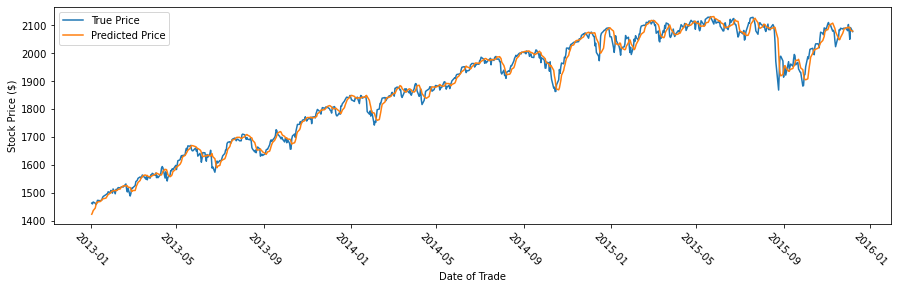

In [78]:
features_updated = ['day_5', 'day_30', 'day_365', 'ratio_5_to_365', 'day_5_std', 'day_365_std', 'ratio_std_5_to_365',
           'volume_5', 'volume_30', 'volume_365', 'volume_5_to_365', 'volume_5_std',
            'volume_365_std', 'volume_std_5_to_365']

lr_updated = lr_train_test(df, features_updated)

## Feature Importance

It is interesting to see that there was no significant change in both the MAE and RMSE when the volume related features were used. It would be beneficial to see the importance of each feature to the model, and the degree of effect it has on the predictions made.

Feature: day_5, Score: 1.06228
Feature: day_30, Score: -0.06319
Feature: day_365, Score: -0.00079
Feature: ratio_5_to_365, Score: -1.32341
Feature: day_5_std, Score: -0.09302
Feature: day_365_std, Score: 0.02701
Feature: ratio_std_5_to_365, Score: 0.49765
Feature: volume_5, Score: -0.00000
Feature: volume_30, Score: 0.00000
Feature: volume_365, Score: 0.00000
Feature: volume_5_to_365, Score: 1.49922
Feature: volume_5_std, Score: 0.00000
Feature: volume_365_std, Score: -0.00000
Feature: volume_std_5_to_365, Score: -0.19601


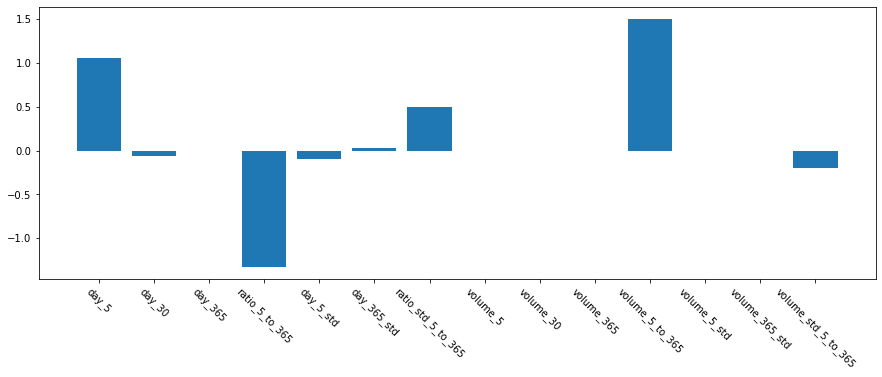

In [79]:
importance = lr_updated.coef_

for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (features_updated[i],v))
# plot feature importance
fig = plt.figure(figsize = (15,5))
plt.bar(features_updated, importance)
plt.xticks(rotation=-45)
plt.show()

**discuss results of the feature importance**

## Feature Selection

The MAE is 16.13, and the RMSE is 22.13


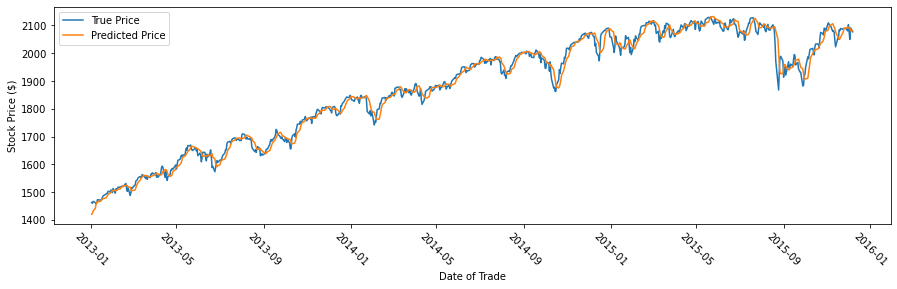

LinearRegression()

In [80]:
features_reduced = ['day_5', 'ratio_5_to_365', 'day_5_std', 'ratio_std_5_to_365',
                    'volume_5_to_365','volume_std_5_to_365']

lr_train_test(df, features_reduced)

**discuss results**